# Assignment3

## Import libraries

In [68]:
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging, sys
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, SimpleRNN, GRU, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.optimizers import Adam, SGD, RMSprop
import matplotlib.dates as mdates

## Data preprocessing & visualization 

In [69]:
df = pd.read_csv('data/Google_Stock_Price_Train.csv')

In [70]:
df['Date']=pd.to_datetime(df['Date'])
df.set_index('Date',drop=True,inplace=True)
df['Volume'] = df['Volume'].str.replace(',', '').astype(float)
df['Close'] = df['Close'].str.replace(',', '').astype(float)

/var/folders/_6/bkb79v1n1qgb5pjgnzbz79nw0000gn/T/ipykernel_88771/949419411.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


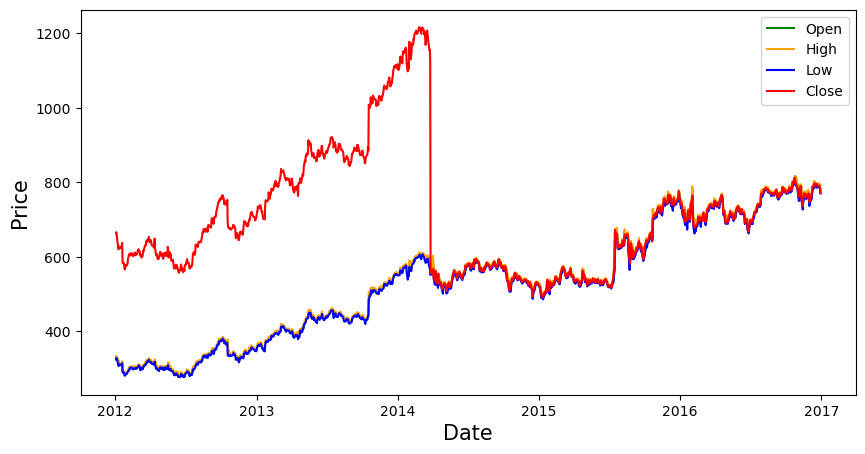

In [71]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(df['Open'], label='Open', color='green')
ax.plot(df['High'], label='High', color='orange')
ax.plot(df['Low'],label='Low',color='blue')
ax.plot(df['Close'],label='Close',color='red')
ax.set_xlabel('Date',size=15)
ax.set_ylabel('Price',size=15)
ax.legend()

fig.show()

In [72]:
df_test = pd.read_csv('data/Google_Stock_Price_Test.csv')

In [73]:
df_test['Date']=pd.to_datetime(df_test['Date'])
df_test.set_index('Date',drop=True,inplace=True)
df_test['Volume'] = df_test['Volume'].str.replace(',', '').astype(float)
# df_test['Close'] = df_test['Close'].str.replace(',', '').astype(float)

/var/folders/_6/bkb79v1n1qgb5pjgnzbz79nw0000gn/T/ipykernel_88771/4245089645.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


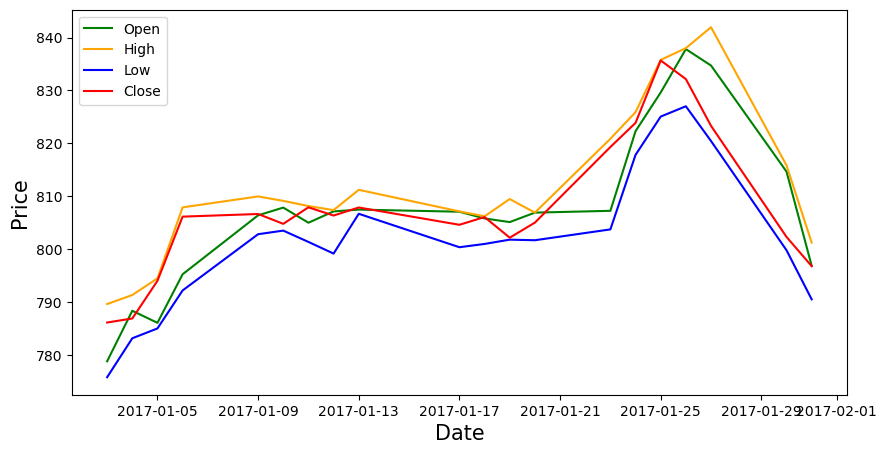

In [74]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(df_test['Open'], label='Open', color='green')
ax.plot(df_test['High'], label='High', color='orange')
ax.plot(df_test['Low'],label='Low',color='blue')
ax.plot(df_test['Close'],label='Close',color='red')
ax.set_xlabel('Date',size=15)
ax.set_ylabel('Price',size=15)
ax.legend()

fig.show()

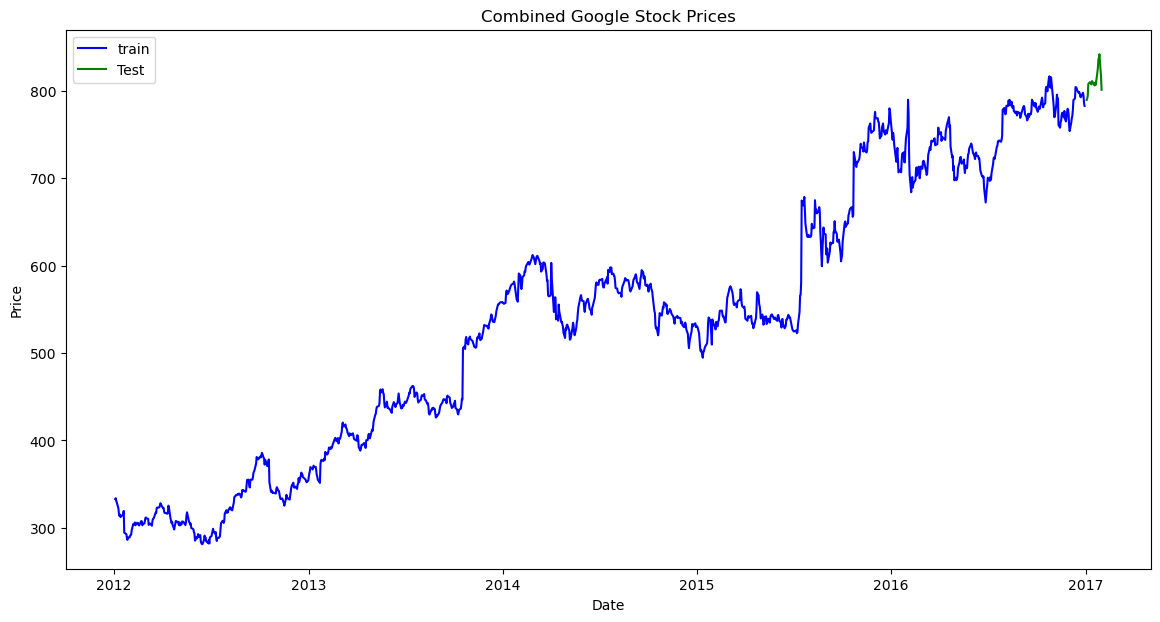

In [75]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df and df_test are already loaded and preprocessed DataFrames
# Combine the two dataframes
combined_df = pd.concat([df, df_test])

# Plot the combined data
plt.figure(figsize=(14, 7))

# Plot the part from df with one color
plt.plot(df['High'], label='train', color='blue')

# Plot the part from df_test with another color
plt.plot(df_test['High'], label='Test', color='green')

plt.title('Combined Google Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [76]:
# Scaling the 'High' feature
scaler = MinMaxScaler(feature_range=(0, 1))
df['High'] = scaler.fit_transform(df[['High']])
df_test['High'] = scaler.fit_transform(df_test[['High']])

# Splitting the data into training and validation sets
train_size = int(len(df) * 0.75)
train, validation = df[:train_size], df[train_size:]
test = df_test

In [77]:
print(validation['High'])

Date
2015-10-02    0.646404
2015-10-05    0.675668
2015-10-06    0.687321
2015-10-07    0.689861
2015-10-08    0.678357
                ...   
2016-12-23    0.955292
2016-12-27    0.964853
2016-12-28    0.958074
2016-12-29    0.942574
2016-12-30    0.936691
Name: High, Length: 315, dtype: float64


In [78]:
def create_dataset_with_dates(values, dates, look_back=1):
    X, y, X_dates = [], [], []
    for i in range(len(values) - look_back):
        X.append(values[i:(i + look_back)])
        y.append(values[i + look_back])
        X_dates.append(dates[i + look_back])  # Collects the corresponding date
    return np.array(X), np.array(y), np.array(X_dates)

## Comparison among models

In [79]:
# Part 1: Compare RNN, LSTM, GRU with Different Window Sizes Using the Adam Optimizer
# Define model initialization functions that accept an optimizer
def init_rnn(input_shape, output_units, optimizer='adam'):
    model = Sequential()
    model.add(SimpleRNN(50, input_shape=input_shape, return_sequences=True))
    model.add(SimpleRNN(50))
    model.add(Dense(output_units))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

def init_lstm(input_shape, output_units, optimizer='adam'):
    model = Sequential()
    model.add(LSTM(50, input_shape=input_shape, return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(output_units))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

def init_gru(input_shape, output_units, optimizer='adam'):
    model = Sequential()
    model.add(GRU(50, input_shape=input_shape, return_sequences=True))
    model.add(GRU(50))
    model.add(Dense(output_units))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Data preparation function including date handling
def create_dataset_with_dates(values, dates, look_back=1):
    X, y, X_dates = [], [], []
    for i in range(len(values) - look_back):
        X.append(values[i:(i + look_back)])
        y.append(values[i + look_back])
        X_dates.append(dates[i + look_back])  # Collects the corresponding date
    return np.array(X), np.array(y), np.array(X_dates)

look_backs = [10, 20, 30]
models = {'RNN': init_rnn, 'LSTM': init_lstm, 'GRU': init_gru}
models_storage = {}
performance_log = {}

# Directory for plots
plot_dir = "training_plots_part1"
os.makedirs(plot_dir, exist_ok=True)

# Training and plotting
optimizer = Adam()  # Use Adam optimizer for all models in this part
for name, init_func in models.items():
    for look_back in look_backs:
        X_train, y_train, _ = create_dataset_with_dates(train['High'].values, train.index.values, look_back)
        X_val, y_val, dates_val = create_dataset_with_dates(validation['High'].values, validation.index.values, look_back)

        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

        model = init_func((X_train.shape[1], 1), 1, optimizer)
        history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=2)

        predictions = model.predict(X_val)
        mse = mean_squared_error(y_val, predictions)
        mae = mean_absolute_error(y_val, predictions)

        # Store the model and its performance
        key = (name, look_back)
        models_storage[key] = model
        performance_log[key] = {'MSE': mse, 'MAE': mae}

        # Plot and save training & validation loss
        plt.figure(figsize=(10, 4))
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'Training and Validation Loss for {name} with Look Back {look_back}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig(os.path.join(plot_dir, f"{name}_{look_back}_loss.png"))
        plt.show()
        plt.close()

        # Plot and save actual vs predicted values
        plt.figure(figsize=(10, 4))
        plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        plt.plot(dates_val, y_val, label='Actual', color='blue')
        plt.plot(dates_val, predictions.flatten(), label='Predicted', color='orange', alpha=0.7)
        plt.title(f'Actual vs Predicted for {name} with Look Back {look_back}')
        plt.xlabel('Date')
        plt.ylabel('Normalized Value')
        plt.legend()
        plt.gcf().autofmt_xdate(rotation=0)  # Adjust for non-inclined date labels
        plt.savefig(os.path.join(plot_dir, f"{name}_{look_back}_prediction.png"))
        plt.show()
        plt.close()


# Outputting performance for each model configuration
for config, metrics in performance_log.items():
    print(f"Model Type: {config[0]}, Look Back: {config[1]}, MSE: {metrics['MSE']}, MAE: {metrics['MAE']}")

# Output best model configuration from Part 1
best_model_key = min(performance_log, key=lambda x: performance_log[x]['MSE'])
print("\nPart 1 - Best Model Configuration:")
print(f"Model Type: {best_model_key[0]}, Look Back: {best_model_key[1]}")
print(f"MSE: {performance_log[best_model_key]['MSE']}, MAE: {performance_log[best_model_key]['MAE']}")

Epoch 1/50
30/30 - 1s - loss: 0.1297 - val_loss: 0.1357 - 629ms/epoch - 21ms/step
Epoch 2/50
30/30 - 0s - loss: 0.0063 - val_loss: 0.0540 - 66ms/epoch - 2ms/step
Epoch 3/50
30/30 - 0s - loss: 0.0019 - val_loss: 0.0353 - 67ms/epoch - 2ms/step
Epoch 4/50
30/30 - 0s - loss: 0.0012 - val_loss: 0.0213 - 74ms/epoch - 2ms/step
Epoch 5/50
30/30 - 0s - loss: 0.0011 - val_loss: 0.0150 - 77ms/epoch - 3ms/step
Epoch 6/50
30/30 - 0s - loss: 0.0010 - val_loss: 0.0094 - 71ms/epoch - 2ms/step
Epoch 7/50
30/30 - 0s - loss: 9.9512e-04 - val_loss: 0.0145 - 70ms/epoch - 2ms/step
Epoch 8/50
30/30 - 0s - loss: 9.1755e-04 - val_loss: 0.0122 - 71ms/epoch - 2ms/step
Epoch 9/50
30/30 - 0s - loss: 8.8253e-04 - val_loss: 0.0097 - 71ms/epoch - 2ms/step
Epoch 10/50
30/30 - 0s - loss: 8.2887e-04 - val_loss: 0.0080 - 70ms/epoch - 2ms/step
Epoch 11/50
30/30 - 0s - loss: 7.3098e-04 - val_loss: 0.0084 - 70ms/epoch - 2ms/step
Epoch 12/50
30/30 - 0s - loss: 7.8376e-04 - val_loss: 0.0051 - 71ms/epoch - 2ms/step
Epoch 13/50

2024-12-07 08:00:13.214500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-07 08:00:13.214961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-07 08:00:13.215461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

30/30 - 2s - loss: 0.0194 - val_loss: 0.0030 - 2s/epoch - 60ms/step
Epoch 2/50
30/30 - 0s - loss: 8.8334e-04 - val_loss: 0.0056 - 183ms/epoch - 6ms/step
Epoch 3/50
30/30 - 0s - loss: 7.1121e-04 - val_loss: 0.0045 - 171ms/epoch - 6ms/step
Epoch 4/50
30/30 - 0s - loss: 6.8177e-04 - val_loss: 0.0047 - 163ms/epoch - 5ms/step
Epoch 5/50
30/30 - 0s - loss: 6.6441e-04 - val_loss: 0.0035 - 163ms/epoch - 5ms/step
Epoch 6/50
30/30 - 0s - loss: 6.7973e-04 - val_loss: 0.0026 - 159ms/epoch - 5ms/step
Epoch 7/50
30/30 - 0s - loss: 6.4174e-04 - val_loss: 0.0037 - 152ms/epoch - 5ms/step
Epoch 8/50
30/30 - 0s - loss: 6.3630e-04 - val_loss: 0.0040 - 152ms/epoch - 5ms/step
Epoch 9/50
30/30 - 0s - loss: 6.3606e-04 - val_loss: 0.0028 - 145ms/epoch - 5ms/step
Epoch 10/50
30/30 - 0s - loss: 6.1807e-04 - val_loss: 0.0035 - 141ms/epoch - 5ms/step
Epoch 11/50
30/30 - 0s - loss: 6.0752e-04 - val_loss: 0.0027 - 146ms/epoch - 5ms/step
Epoch 12/50
30/30 - 0s - loss: 5.9987e-04 - val_loss: 0.0033 - 145ms/epoch - 5ms

2024-12-07 08:00:22.691604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-07 08:00:22.692074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-07 08:00:22.692521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 1s 2ms/step


2024-12-07 08:00:23.760777: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-07 08:00:23.761261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-07 08:00:23.762054: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2024-12-07 08:00:24.065664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-07 08:00:24.066131: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-07 08:00:24.067570: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

29/29 - 2s - loss: 0.0151 - val_loss: 0.0263 - 2s/epoch - 62ms/step
Epoch 2/50
29/29 - 0s - loss: 0.0015 - val_loss: 0.0131 - 232ms/epoch - 8ms/step
Epoch 3/50
29/29 - 0s - loss: 7.8408e-04 - val_loss: 0.0074 - 244ms/epoch - 8ms/step
Epoch 4/50
29/29 - 0s - loss: 7.4880e-04 - val_loss: 0.0070 - 241ms/epoch - 8ms/step
Epoch 5/50
29/29 - 0s - loss: 7.0085e-04 - val_loss: 0.0047 - 230ms/epoch - 8ms/step
Epoch 6/50
29/29 - 0s - loss: 7.1629e-04 - val_loss: 0.0077 - 228ms/epoch - 8ms/step
Epoch 7/50
29/29 - 0s - loss: 7.4683e-04 - val_loss: 0.0050 - 267ms/epoch - 9ms/step
Epoch 8/50
29/29 - 0s - loss: 6.6687e-04 - val_loss: 0.0055 - 256ms/epoch - 9ms/step
Epoch 9/50
29/29 - 0s - loss: 7.0572e-04 - val_loss: 0.0034 - 234ms/epoch - 8ms/step
Epoch 10/50
29/29 - 0s - loss: 6.2767e-04 - val_loss: 0.0021 - 282ms/epoch - 10ms/step
Epoch 11/50
29/29 - 0s - loss: 6.1352e-04 - val_loss: 0.0024 - 239ms/epoch - 8ms/step
Epoch 12/50
29/29 - 0s - loss: 5.9789e-04 - val_loss: 0.0022 - 232ms/epoch - 8ms/st

2024-12-07 08:00:37.580077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-07 08:00:37.580673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-07 08:00:37.581187: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 0s 2ms/step
Epoch 1/50


2024-12-07 08:00:37.958805: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-07 08:00:37.959282: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-07 08:00:37.960049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

29/29 - 2s - loss: 0.0339 - val_loss: 0.0053 - 2s/epoch - 63ms/step
Epoch 2/50
29/29 - 0s - loss: 0.0013 - val_loss: 0.0026 - 326ms/epoch - 11ms/step
Epoch 3/50
29/29 - 0s - loss: 7.9351e-04 - val_loss: 0.0025 - 326ms/epoch - 11ms/step
Epoch 4/50
29/29 - 0s - loss: 7.4115e-04 - val_loss: 0.0025 - 314ms/epoch - 11ms/step
Epoch 5/50
29/29 - 0s - loss: 7.2843e-04 - val_loss: 0.0032 - 333ms/epoch - 11ms/step
Epoch 6/50
29/29 - 0s - loss: 7.0484e-04 - val_loss: 0.0026 - 337ms/epoch - 12ms/step
Epoch 7/50
29/29 - 0s - loss: 7.0890e-04 - val_loss: 0.0021 - 337ms/epoch - 12ms/step
Epoch 8/50
29/29 - 0s - loss: 6.8563e-04 - val_loss: 0.0033 - 420ms/epoch - 14ms/step
Epoch 9/50
29/29 - 0s - loss: 6.7528e-04 - val_loss: 0.0018 - 330ms/epoch - 11ms/step
Epoch 10/50
29/29 - 0s - loss: 6.6695e-04 - val_loss: 0.0018 - 328ms/epoch - 11ms/step
Epoch 11/50
29/29 - 0s - loss: 6.3830e-04 - val_loss: 0.0020 - 342ms/epoch - 12ms/step
Epoch 12/50
29/29 - 0s - loss: 6.5663e-04 - val_loss: 0.0017 - 320ms/epoch

2024-12-07 08:00:56.737233: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-07 08:00:56.737989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-07 08:00:56.738561: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

9/9 [==============================] - 0s 3ms/step
Epoch 1/50


2024-12-07 08:00:57.141545: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-07 08:00:57.142439: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-07 08:00:57.143036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

30/30 - 2s - loss: 0.0151 - val_loss: 0.0016 - 2s/epoch - 58ms/step
Epoch 2/50
30/30 - 0s - loss: 5.8165e-04 - val_loss: 0.0011 - 148ms/epoch - 5ms/step
Epoch 3/50
30/30 - 0s - loss: 3.6880e-04 - val_loss: 5.9700e-04 - 148ms/epoch - 5ms/step
Epoch 4/50
30/30 - 0s - loss: 3.6131e-04 - val_loss: 5.3216e-04 - 142ms/epoch - 5ms/step
Epoch 5/50
30/30 - 0s - loss: 3.6719e-04 - val_loss: 7.0617e-04 - 138ms/epoch - 5ms/step
Epoch 6/50
30/30 - 0s - loss: 3.2056e-04 - val_loss: 5.9841e-04 - 138ms/epoch - 5ms/step
Epoch 7/50
30/30 - 0s - loss: 3.1369e-04 - val_loss: 4.7494e-04 - 142ms/epoch - 5ms/step
Epoch 8/50
30/30 - 0s - loss: 3.1874e-04 - val_loss: 5.9257e-04 - 139ms/epoch - 5ms/step
Epoch 9/50
30/30 - 0s - loss: 2.8906e-04 - val_loss: 5.9410e-04 - 143ms/epoch - 5ms/step
Epoch 10/50
30/30 - 0s - loss: 2.9460e-04 - val_loss: 8.9413e-04 - 139ms/epoch - 5ms/step
Epoch 11/50
30/30 - 0s - loss: 2.8345e-04 - val_loss: 5.0990e-04 - 139ms/epoch - 5ms/step
Epoch 12/50
30/30 - 0s - loss: 2.7319e-04 - 

2024-12-07 08:01:05.993034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-07 08:01:05.993529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-07 08:01:05.994048: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2024-12-07 08:01:06.354732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-07 08:01:06.355211: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-07 08:01:06.355745: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

29/29 - 2s - loss: 0.0099 - val_loss: 0.0019 - 2s/epoch - 61ms/step
Epoch 2/50
29/29 - 0s - loss: 3.6353e-04 - val_loss: 3.7732e-04 - 241ms/epoch - 8ms/step
Epoch 3/50
29/29 - 0s - loss: 2.5062e-04 - val_loss: 3.4096e-04 - 241ms/epoch - 8ms/step
Epoch 4/50
29/29 - 0s - loss: 2.4528e-04 - val_loss: 3.1825e-04 - 232ms/epoch - 8ms/step
Epoch 5/50
29/29 - 0s - loss: 2.2790e-04 - val_loss: 3.6123e-04 - 232ms/epoch - 8ms/step
Epoch 6/50
29/29 - 0s - loss: 2.2497e-04 - val_loss: 2.9031e-04 - 233ms/epoch - 8ms/step
Epoch 7/50
29/29 - 0s - loss: 2.0610e-04 - val_loss: 2.7604e-04 - 236ms/epoch - 8ms/step
Epoch 8/50
29/29 - 0s - loss: 1.9908e-04 - val_loss: 2.8200e-04 - 233ms/epoch - 8ms/step
Epoch 9/50
29/29 - 0s - loss: 2.0049e-04 - val_loss: 5.8460e-04 - 237ms/epoch - 8ms/step
Epoch 10/50
29/29 - 0s - loss: 1.9797e-04 - val_loss: 2.6293e-04 - 237ms/epoch - 8ms/step
Epoch 11/50
29/29 - 0s - loss: 1.9310e-04 - val_loss: 2.5516e-04 - 235ms/epoch - 8ms/step
Epoch 12/50
29/29 - 0s - loss: 1.8864e-0

2024-12-07 08:01:20.039332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-07 08:01:20.039824: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-07 08:01:20.040311: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2024-12-07 08:01:20.396546: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-07 08:01:20.397106: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-07 08:01:20.397556: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

29/29 - 2s - loss: 0.0152 - val_loss: 4.7133e-04 - 2s/epoch - 64ms/step
Epoch 2/50
29/29 - 0s - loss: 5.3020e-04 - val_loss: 5.8221e-04 - 329ms/epoch - 11ms/step
Epoch 3/50
29/29 - 0s - loss: 2.8797e-04 - val_loss: 4.8228e-04 - 326ms/epoch - 11ms/step
Epoch 4/50
29/29 - 0s - loss: 2.5258e-04 - val_loss: 4.1864e-04 - 321ms/epoch - 11ms/step
Epoch 5/50
29/29 - 0s - loss: 2.3023e-04 - val_loss: 3.3122e-04 - 321ms/epoch - 11ms/step
Epoch 6/50
29/29 - 0s - loss: 2.2154e-04 - val_loss: 3.1279e-04 - 325ms/epoch - 11ms/step
Epoch 7/50
29/29 - 0s - loss: 2.1848e-04 - val_loss: 2.9758e-04 - 324ms/epoch - 11ms/step
Epoch 8/50
29/29 - 0s - loss: 2.1048e-04 - val_loss: 2.9773e-04 - 323ms/epoch - 11ms/step
Epoch 9/50
29/29 - 0s - loss: 2.0641e-04 - val_loss: 3.4455e-04 - 322ms/epoch - 11ms/step
Epoch 10/50
29/29 - 0s - loss: 1.9917e-04 - val_loss: 3.0868e-04 - 323ms/epoch - 11ms/step
Epoch 11/50
29/29 - 0s - loss: 2.2141e-04 - val_loss: 2.8053e-04 - 326ms/epoch - 11ms/step
Epoch 12/50
29/29 - 0s - l

2024-12-07 08:01:38.715819: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-07 08:01:38.716599: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-07 08:01:38.717265: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

9/9 [==============================] - 1s 3ms/step


2024-12-07 08:01:39.392165: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-07 08:01:39.392661: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-07 08:01:39.393336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model Type: RNN, Look Back: 10, MSE: 0.0006357477572800841, MAE: 0.02002175226933622
Model Type: RNN, Look Back: 20, MSE: 0.0008744914207457151, MAE: 0.025147483625481703
Model Type: RNN, Look Back: 30, MSE: 0.0029624541837245137, MAE: 0.050636579142926616
Model Type: LSTM, Look Back: 10, MSE: 0.0022753934522918157, MAE: 0.04346613968506732
Model Type: LSTM, Look Back: 20, MSE: 0.0008574953063865472, MAE: 0.0245615895687435
Model Type: LSTM, Look Back: 30, MSE: 0.0006245278184048354, MAE: 0.01929465398031155
Model Type: GRU, Look Back: 10, MSE: 0.0003470785855705543, MAE: 0.013453025356429716
Model Type: GRU, Look Back: 20, MSE: 0.0002907720680968841, MAE: 0.013102042982641525
Model Type: GRU, Look Back: 30, MSE: 0.0005937864762707542, MAE: 0.021204668994100808

Part 1 - Best Model Configuration:
Model Type: GRU, Look Back: 20
MSE: 0.0002907720680968841, MAE: 0.013102042982641525


Model: RNN, Look Back: 10, X_val shape: (305, 10, 1)
10/10 [==============================] - 0s 876us/step
Model: LSTM, Look Back: 30, X_val shape: (285, 30, 1)
9/9 [==============================] - 0s 3ms/step
Model: GRU, Look Back: 20, X_val shape: (295, 20, 1)
10/10 [==============================] - 0s 2ms/step


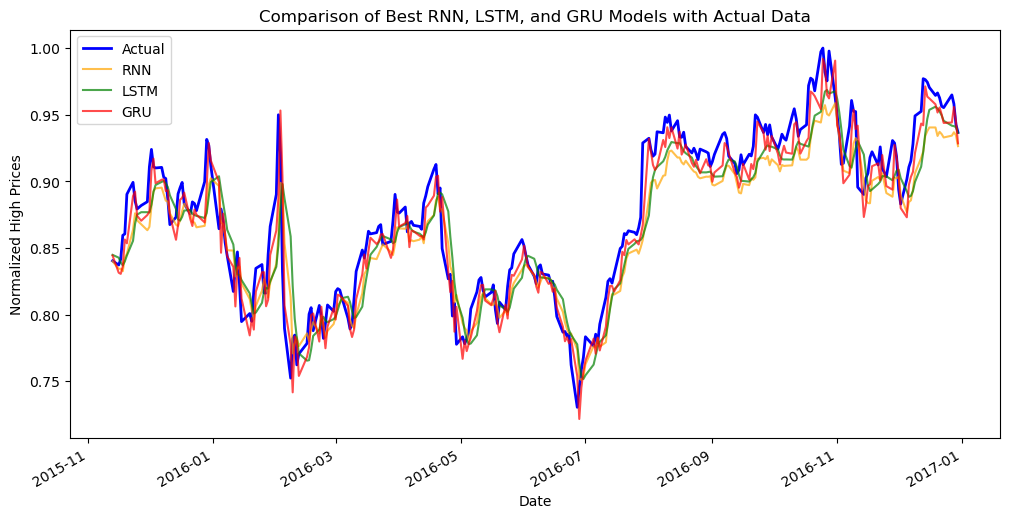


Ready for Part 2 with best model: GRU


In [106]:
best_models = {}
best_predictions = {}
best_dates = {}

# For each model type, find the best performing look_back based on MSE
for model_type in ['RNN', 'LSTM', 'GRU']:
    best_mse = float('inf')
    best_key = None
    for key in performance_log:
        if key[0] == model_type and performance_log[key]['MSE'] < best_mse:
            best_mse = performance_log[key]['MSE']
            best_key = key

    if best_key:
        # Recreate the validation set for the chosen look_back
        X_val, y_val, dates_val = create_dataset_with_dates(validation['High'].values, validation.index.values, best_key[1])
        X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

        print(f"Model: {model_type}, Look Back: {best_key[1]}, X_val shape: {X_val.shape}")

        best_models[model_type] = models_storage[best_key]
        predictions = best_models[model_type].predict(X_val)
        predictions = predictions.flatten()

        # Filter the dates and predictions to include only those where actual data is available
        valid_indices = [i for i, date in enumerate(dates_val) if date in validation.index.values]
        filtered_dates = dates_val[valid_indices]
        filtered_predictions = predictions[valid_indices]

        best_predictions[model_type] = filtered_predictions
        best_dates[model_type] = filtered_dates

# Now we have best_predictions and best_dates for each model.
# Next, align all predictions and actual values using the intersection of dates.

all_dates_sets = [set(d) for d in best_dates.values()]
common_dates_set = set.intersection(*all_dates_sets)
common_dates = sorted(list(common_dates_set))

# Align predictions for all models
aligned_predictions = {}
for model_type in best_predictions:
    date_to_idx = {date: idx for idx, date in enumerate(best_dates[model_type])}
    indices = [date_to_idx[d] for d in common_dates if d in date_to_idx]
    aligned_predictions[model_type] = best_predictions[model_type][indices]

# Align the actual y_val according to common_dates
# We need y_val and dates_val that correspond to the same scenario as predictions.
# Let's take one of the best models (best_model_key) as reference:
reference_look_back = best_model_key[1]
X_val_ref, y_val_ref, dates_val_ref = create_dataset_with_dates(validation['High'].values, validation.index.values, reference_look_back)
# Map dates_val_ref to indices
date_to_idx_ref = {date: idx for idx, date in enumerate(dates_val_ref)}
indices_ref = [date_to_idx_ref[d] for d in common_dates if d in date_to_idx_ref]
y_val_aligned = y_val_ref[indices_ref]

plt.figure(figsize=(12, 6))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Plot the actual aligned values
plt.plot(common_dates, y_val_aligned, label='Actual', color='blue', linewidth=2)

colors = {'RNN': 'orange', 'LSTM': 'green', 'GRU': 'red'}
for model_type in aligned_predictions:
    plt.plot(common_dates, aligned_predictions[model_type], 
             label=model_type, color=colors[model_type], alpha=0.7)

plt.title('Comparison of Best RNN, LSTM, and GRU Models with Actual Data')
plt.xlabel('Date')
plt.ylabel('Normalized High Prices')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

# Prepare for Part 2 based on the best model from Part 1
best_model_type = best_model_key[0]
print("\nReady for Part 2 with best model:", best_model_type)

## Further Improvement

In [84]:
# Part 2: Explore Different Optimizers for the Best Model Type from Part 1

from tensorflow.keras.optimizers import Adam, SGD, RMSprop

# Adjust model initialization functions to accept an optimizer choice
def get_model(init_func, input_shape, output_units, optimizer):
    return init_func(input_shape, output_units, optimizer)

# Prepare the directory to store plots from Part 2
plot_dir_part2 = "training_plots_part2"
os.makedirs(plot_dir_part2, exist_ok=True)

# Optimizers to explore
optimizers = {
    'Adam': Adam(), 
    'SGD': SGD(learning_rate=0.01, momentum=0.0, nesterov=False), 
    'RMSprop': RMSprop()
}

# Define the model initialization based on the best model type from Part 1
init_func = models[best_model_type]

# Extended range of look-backs for further exploration
look_backs = [10, 20, 30, 40, 50]

# Storage for models
models_storage_part2 = {}

# Performance tracking
performance_log_part2 = {}

# Training and plotting
for look_back in look_backs:
    for opt_name, optimizer in optimizers.items():
        X_train, y_train, _ = create_dataset_with_dates(train['High'].values, train.index.values, look_back)
        X_val, y_val, dates_val = create_dataset_with_dates(validation['High'].values, validation.index.values, look_back)

        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

        model = get_model(init_func, (X_train.shape[1], 1), 1, optimizer)
        history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=2)

        predictions = model.predict(X_val)
        mse = mean_squared_error(y_val, predictions)
        mae = mean_absolute_error(y_val, predictions)

        # Store performance data and the model
        key = (best_model_type, look_back, opt_name)
        models_storage_part2[key] = model
        performance_log_part2[key] = {'MSE': mse, 'MAE': mae}

        # Save training & validation loss plot
        plt.figure(figsize=(10, 4))
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'Part 2 - {opt_name} Loss for {best_model_type} with Look Back {look_back}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig(os.path.join(plot_dir_part2, f"{opt_name}_{look_back}_loss.png"))
        plt.close()

        # Save actual vs predicted plot
        plt.figure(figsize=(10, 4))
        plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        plt.plot(dates_val, y_val, label='Actual', color='blue')
        plt.plot(dates_val, predictions.flatten(), label='Predicted', color='orange', alpha=0.7)
        plt.title(f'Part 2 - Actual vs Predicted {opt_name} for {best_model_type} with Look Back {look_back}')
        plt.xlabel('Date')
        plt.ylabel('Normalized Value')
        plt.legend()
        plt.gcf().autofmt_xdate(rotation=0)
        plt.savefig(os.path.join(plot_dir_part2, f"{opt_name}_{look_back}_prediction.png"))
        plt.close()

# Outputting performance for each model configuration
for config, metrics in performance_log_part2.items():
    print(f"Model Type: {config[0]}, Look Back: {config[1]}, Optimizer: {config[2]}, MSE: {metrics['MSE']}, MAE: {metrics['MAE']}")

# Determine the best model configuration from Part 2 based on MSE
best_model_key_part2 = min(performance_log_part2, key=lambda x: performance_log_part2[x]['MSE'])
print("\nPart 2 - Best Model Configuration:")
print(f"Model Type: {best_model_key_part2[0]}, Look Back: {best_model_key_part2[1]}, Optimizer: {best_model_key_part2[2]}")
print(f"MSE: {performance_log_part2[best_model_key_part2]['MSE']}, MAE: {performance_log_part2[best_model_key_part2]['MAE']}")

2024-12-07 08:42:04.527952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-07 08:42:04.528479: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-07 08:42:04.529591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2024-12-07 08:42:04.739156: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-07 08:42:04.739875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-07 08:42:04.740489: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

30/30 - 2s - loss: 0.0183 - val_loss: 0.0043 - 2s/epoch - 60ms/step
Epoch 2/50
30/30 - 0s - loss: 9.2332e-04 - val_loss: 7.1170e-04 - 147ms/epoch - 5ms/step
Epoch 3/50
30/30 - 0s - loss: 4.5296e-04 - val_loss: 8.5664e-04 - 143ms/epoch - 5ms/step
Epoch 4/50
30/30 - 0s - loss: 4.2380e-04 - val_loss: 7.7451e-04 - 135ms/epoch - 5ms/step
Epoch 5/50
30/30 - 0s - loss: 4.1290e-04 - val_loss: 8.3416e-04 - 137ms/epoch - 5ms/step
Epoch 6/50
30/30 - 0s - loss: 4.2292e-04 - val_loss: 6.9746e-04 - 136ms/epoch - 5ms/step
Epoch 7/50
30/30 - 0s - loss: 4.0126e-04 - val_loss: 6.0297e-04 - 137ms/epoch - 5ms/step
Epoch 8/50
30/30 - 0s - loss: 3.8889e-04 - val_loss: 7.1690e-04 - 139ms/epoch - 5ms/step
Epoch 9/50
30/30 - 0s - loss: 3.8202e-04 - val_loss: 7.0595e-04 - 155ms/epoch - 5ms/step
Epoch 10/50
30/30 - 0s - loss: 3.6830e-04 - val_loss: 6.0211e-04 - 139ms/epoch - 5ms/step
Epoch 11/50
30/30 - 0s - loss: 3.5949e-04 - val_loss: 0.0012 - 137ms/epoch - 5ms/step
Epoch 12/50
30/30 - 0s - loss: 3.9638e-04 - 

2024-12-07 08:42:13.354037: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-07 08:42:13.354544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-07 08:42:13.355011: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2024-12-07 08:42:13.885354: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-07 08:42:13.885955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-07 08:42:13.886635: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

30/30 - 2s - loss: 0.0684 - val_loss: 0.2705 - 2s/epoch - 55ms/step


2024-12-07 08:42:15.268367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-07 08:42:15.268936: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-07 08:42:15.269564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 2/50
30/30 - 0s - loss: 0.0362 - val_loss: 0.2402 - 140ms/epoch - 5ms/step
Epoch 3/50
30/30 - 0s - loss: 0.0316 - val_loss: 0.1946 - 140ms/epoch - 5ms/step
Epoch 4/50
30/30 - 0s - loss: 0.0275 - val_loss: 0.1656 - 132ms/epoch - 4ms/step
Epoch 5/50
30/30 - 0s - loss: 0.0240 - val_loss: 0.1431 - 136ms/epoch - 5ms/step
Epoch 6/50
30/30 - 0s - loss: 0.0208 - val_loss: 0.1165 - 134ms/epoch - 4ms/step
Epoch 7/50
30/30 - 0s - loss: 0.0179 - val_loss: 0.1043 - 134ms/epoch - 4ms/step
Epoch 8/50
30/30 - 0s - loss: 0.0153 - val_loss: 0.1003 - 134ms/epoch - 4ms/step
Epoch 9/50
30/30 - 0s - loss: 0.0131 - val_loss: 0.0822 - 136ms/epoch - 5ms/step
Epoch 10/50
30/30 - 0s - loss: 0.0110 - val_loss: 0.0646 - 134ms/epoch - 4ms/step
Epoch 11/50
30/30 - 0s - loss: 0.0093 - val_loss: 0.0510 - 138ms/epoch - 5ms/step
Epoch 12/50
30/30 - 0s - loss: 0.0078 - val_loss: 0.0442 - 134ms/epoch - 4ms/step
Epoch 13/50
30/30 - 0s - loss: 0.0064 - val_loss: 0.0425 - 134ms/epoch - 4ms/step
Epoch 14/50
30/30 - 0s -

2024-12-07 08:42:22.203974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-07 08:42:22.204478: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-07 08:42:22.204953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2024-12-07 08:42:22.735681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-07 08:42:22.736228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-07 08:42:22.736936: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

30/30 - 2s - loss: 0.0105 - val_loss: 0.0063 - 2s/epoch - 57ms/step
Epoch 2/50
30/30 - 0s - loss: 0.0024 - val_loss: 8.5250e-04 - 147ms/epoch - 5ms/step
Epoch 3/50
30/30 - 0s - loss: 0.0013 - val_loss: 0.0019 - 142ms/epoch - 5ms/step
Epoch 4/50
30/30 - 0s - loss: 0.0015 - val_loss: 0.0228 - 136ms/epoch - 5ms/step
Epoch 5/50
30/30 - 0s - loss: 0.0011 - val_loss: 0.0046 - 136ms/epoch - 5ms/step
Epoch 6/50
30/30 - 0s - loss: 0.0010 - val_loss: 8.6303e-04 - 136ms/epoch - 5ms/step
Epoch 7/50
30/30 - 0s - loss: 0.0011 - val_loss: 0.0030 - 138ms/epoch - 5ms/step
Epoch 8/50
30/30 - 0s - loss: 8.5081e-04 - val_loss: 0.0075 - 139ms/epoch - 5ms/step
Epoch 9/50
30/30 - 0s - loss: 7.5341e-04 - val_loss: 0.0065 - 143ms/epoch - 5ms/step
Epoch 10/50
30/30 - 0s - loss: 8.5303e-04 - val_loss: 4.5975e-04 - 135ms/epoch - 4ms/step
Epoch 11/50
30/30 - 0s - loss: 7.4633e-04 - val_loss: 0.0060 - 134ms/epoch - 4ms/step
Epoch 12/50
30/30 - 0s - loss: 6.6633e-04 - val_loss: 0.0022 - 137ms/epoch - 5ms/step
Epoch 

2024-12-07 08:42:31.210293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-07 08:42:31.211083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-07 08:42:31.211740: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 0s 1ms/step


2024-12-07 08:42:31.640420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-07 08:42:31.640873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-07 08:42:31.641869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2024-12-07 08:42:31.814144: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-07 08:42:31.814704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-07 08:42:31.815308: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

29/29 - 2s - loss: 0.0388 - val_loss: 0.0396 - 2s/epoch - 60ms/step
Epoch 2/50
29/29 - 0s - loss: 0.0016 - val_loss: 6.3397e-04 - 262ms/epoch - 9ms/step
Epoch 3/50
29/29 - 0s - loss: 4.8471e-04 - val_loss: 7.7967e-04 - 240ms/epoch - 8ms/step
Epoch 4/50
29/29 - 0s - loss: 4.2806e-04 - val_loss: 7.3604e-04 - 234ms/epoch - 8ms/step
Epoch 5/50
29/29 - 0s - loss: 4.2110e-04 - val_loss: 5.6648e-04 - 228ms/epoch - 8ms/step
Epoch 6/50
29/29 - 0s - loss: 4.0948e-04 - val_loss: 5.2143e-04 - 238ms/epoch - 8ms/step
Epoch 7/50
29/29 - 0s - loss: 3.8800e-04 - val_loss: 8.6291e-04 - 231ms/epoch - 8ms/step
Epoch 8/50
29/29 - 0s - loss: 3.8114e-04 - val_loss: 7.2407e-04 - 232ms/epoch - 8ms/step
Epoch 9/50
29/29 - 0s - loss: 3.5394e-04 - val_loss: 4.9393e-04 - 239ms/epoch - 8ms/step
Epoch 10/50
29/29 - 0s - loss: 3.4908e-04 - val_loss: 5.6685e-04 - 231ms/epoch - 8ms/step
Epoch 11/50
29/29 - 0s - loss: 3.2669e-04 - val_loss: 4.3478e-04 - 232ms/epoch - 8ms/step
Epoch 12/50
29/29 - 0s - loss: 3.1928e-04 - 

2024-12-07 08:42:44.963658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-07 08:42:44.964162: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-07 08:42:44.964618: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2024-12-07 08:42:45.503130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-07 08:42:45.503717: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-07 08:42:45.504408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

29/29 - 2s - loss: 0.0538 - val_loss: 0.2081 - 2s/epoch - 58ms/step
Epoch 2/50
29/29 - 0s - loss: 0.0270 - val_loss: 0.1700 - 234ms/epoch - 8ms/step
Epoch 3/50
29/29 - 0s - loss: 0.0232 - val_loss: 0.1410 - 233ms/epoch - 8ms/step
Epoch 4/50
29/29 - 0s - loss: 0.0197 - val_loss: 0.1295 - 228ms/epoch - 8ms/step
Epoch 5/50
29/29 - 0s - loss: 0.0168 - val_loss: 0.1065 - 227ms/epoch - 8ms/step
Epoch 6/50
29/29 - 0s - loss: 0.0142 - val_loss: 0.0874 - 229ms/epoch - 8ms/step
Epoch 7/50
29/29 - 0s - loss: 0.0119 - val_loss: 0.0725 - 225ms/epoch - 8ms/step
Epoch 8/50
29/29 - 0s - loss: 0.0099 - val_loss: 0.0603 - 231ms/epoch - 8ms/step
Epoch 9/50
29/29 - 0s - loss: 0.0081 - val_loss: 0.0502 - 229ms/epoch - 8ms/step
Epoch 10/50
29/29 - 0s - loss: 0.0067 - val_loss: 0.0399 - 229ms/epoch - 8ms/step
Epoch 11/50
29/29 - 0s - loss: 0.0055 - val_loss: 0.0349 - 233ms/epoch - 8ms/step
Epoch 12/50
29/29 - 0s - loss: 0.0044 - val_loss: 0.0296 - 225ms/epoch - 8ms/step
Epoch 13/50
29/29 - 0s - loss: 0.0036 

2024-12-07 08:42:58.412874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-07 08:42:58.413390: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-07 08:42:58.413855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 0s 2ms/step


2024-12-07 08:42:58.789656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-07 08:42:58.790568: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-07 08:42:58.791205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2024-12-07 08:42:58.968266: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-07 08:42:58.968831: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-07 08:42:58.969350: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

29/29 - 2s - loss: 0.0130 - val_loss: 0.0111 - 2s/epoch - 60ms/step
Epoch 2/50
29/29 - 0s - loss: 0.0021 - val_loss: 0.0162 - 236ms/epoch - 8ms/step
Epoch 3/50
29/29 - 0s - loss: 0.0014 - val_loss: 0.0159 - 235ms/epoch - 8ms/step
Epoch 4/50
29/29 - 0s - loss: 0.0013 - val_loss: 0.0025 - 229ms/epoch - 8ms/step
Epoch 5/50
29/29 - 0s - loss: 0.0014 - val_loss: 0.0213 - 229ms/epoch - 8ms/step
Epoch 6/50
29/29 - 0s - loss: 0.0011 - val_loss: 0.0046 - 228ms/epoch - 8ms/step
Epoch 7/50
29/29 - 0s - loss: 0.0012 - val_loss: 5.4109e-04 - 228ms/epoch - 8ms/step
Epoch 8/50
29/29 - 0s - loss: 8.9846e-04 - val_loss: 0.0027 - 225ms/epoch - 8ms/step
Epoch 9/50
29/29 - 0s - loss: 7.7940e-04 - val_loss: 0.0019 - 228ms/epoch - 8ms/step
Epoch 10/50
29/29 - 0s - loss: 8.3876e-04 - val_loss: 0.0015 - 229ms/epoch - 8ms/step
Epoch 11/50
29/29 - 0s - loss: 8.0679e-04 - val_loss: 0.0084 - 230ms/epoch - 8ms/step
Epoch 12/50
29/29 - 0s - loss: 9.6445e-04 - val_loss: 4.8549e-04 - 231ms/epoch - 8ms/step
Epoch 13/5

2024-12-07 08:43:11.988927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-07 08:43:11.989408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-07 08:43:11.989861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2024-12-07 08:43:12.514290: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-07 08:43:12.514850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-07 08:43:12.515360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

29/29 - 2s - loss: 0.0204 - val_loss: 0.0137 - 2s/epoch - 62ms/step
Epoch 2/50
29/29 - 0s - loss: 0.0012 - val_loss: 6.5523e-04 - 330ms/epoch - 11ms/step
Epoch 3/50
29/29 - 0s - loss: 4.7520e-04 - val_loss: 7.6387e-04 - 331ms/epoch - 11ms/step
Epoch 4/50
29/29 - 0s - loss: 4.3835e-04 - val_loss: 7.2870e-04 - 315ms/epoch - 11ms/step
Epoch 5/50
29/29 - 0s - loss: 4.0792e-04 - val_loss: 5.6208e-04 - 314ms/epoch - 11ms/step
Epoch 6/50
29/29 - 0s - loss: 3.8457e-04 - val_loss: 6.8777e-04 - 314ms/epoch - 11ms/step
Epoch 7/50
29/29 - 0s - loss: 3.7053e-04 - val_loss: 9.0764e-04 - 311ms/epoch - 11ms/step
Epoch 8/50
29/29 - 0s - loss: 3.6929e-04 - val_loss: 5.8340e-04 - 312ms/epoch - 11ms/step
Epoch 9/50
29/29 - 0s - loss: 3.4760e-04 - val_loss: 5.0215e-04 - 312ms/epoch - 11ms/step
Epoch 10/50
29/29 - 0s - loss: 3.3241e-04 - val_loss: 6.5170e-04 - 311ms/epoch - 11ms/step
Epoch 11/50
29/29 - 0s - loss: 3.2292e-04 - val_loss: 9.3452e-04 - 315ms/epoch - 11ms/step
Epoch 12/50
29/29 - 0s - loss: 3.1

2024-12-07 08:43:29.857972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-07 08:43:29.858469: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-07 08:43:29.858918: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2024-12-07 08:43:30.393444: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-07 08:43:30.394395: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-07 08:43:30.395018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

29/29 - 2s - loss: 0.0541 - val_loss: 0.2012 - 2s/epoch - 63ms/step
Epoch 2/50
29/29 - 0s - loss: 0.0275 - val_loss: 0.1605 - 324ms/epoch - 11ms/step
Epoch 3/50
29/29 - 0s - loss: 0.0231 - val_loss: 0.1364 - 324ms/epoch - 11ms/step
Epoch 4/50
29/29 - 0s - loss: 0.0195 - val_loss: 0.1159 - 326ms/epoch - 11ms/step
Epoch 5/50
29/29 - 0s - loss: 0.0162 - val_loss: 0.1045 - 329ms/epoch - 11ms/step
Epoch 6/50
29/29 - 0s - loss: 0.0135 - val_loss: 0.0817 - 326ms/epoch - 11ms/step
Epoch 7/50
29/29 - 0s - loss: 0.0111 - val_loss: 0.0656 - 326ms/epoch - 11ms/step
Epoch 8/50
29/29 - 0s - loss: 0.0091 - val_loss: 0.0558 - 326ms/epoch - 11ms/step
Epoch 9/50
29/29 - 0s - loss: 0.0074 - val_loss: 0.0448 - 328ms/epoch - 11ms/step
Epoch 10/50
29/29 - 0s - loss: 0.0060 - val_loss: 0.0393 - 327ms/epoch - 11ms/step
Epoch 11/50
29/29 - 0s - loss: 0.0048 - val_loss: 0.0299 - 328ms/epoch - 11ms/step
Epoch 12/50
29/29 - 0s - loss: 0.0039 - val_loss: 0.0256 - 325ms/epoch - 11ms/step
Epoch 13/50
29/29 - 0s - lo

2024-12-07 08:43:48.287373: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-07 08:43:48.287871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-07 08:43:48.288533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2024-12-07 08:43:48.818853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-07 08:43:48.819402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-07 08:43:48.819921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

29/29 - 2s - loss: 0.0081 - val_loss: 0.0031 - 2s/epoch - 65ms/step
Epoch 2/50
29/29 - 0s - loss: 0.0018 - val_loss: 0.0010 - 319ms/epoch - 11ms/step
Epoch 3/50
29/29 - 0s - loss: 0.0015 - val_loss: 0.0011 - 320ms/epoch - 11ms/step
Epoch 4/50
29/29 - 0s - loss: 0.0012 - val_loss: 0.0041 - 318ms/epoch - 11ms/step
Epoch 5/50
29/29 - 0s - loss: 0.0013 - val_loss: 0.0017 - 315ms/epoch - 11ms/step
Epoch 6/50
29/29 - 0s - loss: 9.9138e-04 - val_loss: 9.8798e-04 - 317ms/epoch - 11ms/step
Epoch 7/50
29/29 - 0s - loss: 0.0010 - val_loss: 0.0049 - 317ms/epoch - 11ms/step
Epoch 8/50
29/29 - 0s - loss: 8.4895e-04 - val_loss: 0.0081 - 316ms/epoch - 11ms/step
Epoch 9/50
29/29 - 0s - loss: 9.2703e-04 - val_loss: 0.0011 - 319ms/epoch - 11ms/step
Epoch 10/50
29/29 - 0s - loss: 9.1109e-04 - val_loss: 0.0014 - 319ms/epoch - 11ms/step
Epoch 11/50
29/29 - 0s - loss: 6.4869e-04 - val_loss: 7.6641e-04 - 316ms/epoch - 11ms/step
Epoch 12/50
29/29 - 0s - loss: 7.2266e-04 - val_loss: 0.0034 - 313ms/epoch - 11ms/

2024-12-07 08:44:10.343906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-07 08:44:10.344828: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-07 08:44:10.345344: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

9/9 [==============================] - 4s 3ms/step


2024-12-07 08:44:10.749126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-07 08:44:10.749764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-07 08:44:10.750307: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2024-12-07 08:44:10.932255: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-07 08:44:10.932860: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-07 08:44:10.933603: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

29/29 - 2s - loss: 0.0397 - val_loss: 0.0507 - 2s/epoch - 67ms/step
Epoch 2/50
29/29 - 0s - loss: 0.0025 - val_loss: 0.0014 - 417ms/epoch - 14ms/step
Epoch 3/50
29/29 - 0s - loss: 5.4883e-04 - val_loss: 7.9469e-04 - 419ms/epoch - 14ms/step
Epoch 4/50
29/29 - 0s - loss: 4.9507e-04 - val_loss: 9.9089e-04 - 419ms/epoch - 14ms/step
Epoch 5/50
29/29 - 0s - loss: 4.7278e-04 - val_loss: 6.2673e-04 - 425ms/epoch - 15ms/step
Epoch 6/50
29/29 - 0s - loss: 4.5319e-04 - val_loss: 6.7583e-04 - 421ms/epoch - 15ms/step
Epoch 7/50
29/29 - 0s - loss: 4.3345e-04 - val_loss: 6.5967e-04 - 420ms/epoch - 14ms/step
Epoch 8/50
29/29 - 0s - loss: 4.2418e-04 - val_loss: 5.6148e-04 - 422ms/epoch - 15ms/step
Epoch 9/50
29/29 - 0s - loss: 4.0277e-04 - val_loss: 5.4102e-04 - 418ms/epoch - 14ms/step
Epoch 10/50
29/29 - 0s - loss: 3.8314e-04 - val_loss: 6.6889e-04 - 424ms/epoch - 15ms/step
Epoch 11/50
29/29 - 0s - loss: 3.7863e-04 - val_loss: 6.3541e-04 - 421ms/epoch - 15ms/step
Epoch 12/50
29/29 - 0s - loss: 3.6463e

2024-12-07 08:44:33.583588: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-07 08:44:33.584091: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-07 08:44:33.584548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2024-12-07 08:44:34.124304: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-07 08:44:34.124867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-07 08:44:34.125508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

29/29 - 2s - loss: 0.0632 - val_loss: 0.2479 - 2s/epoch - 66ms/step
Epoch 2/50
29/29 - 0s - loss: 0.0292 - val_loss: 0.1774 - 408ms/epoch - 14ms/step
Epoch 3/50
29/29 - 0s - loss: 0.0253 - val_loss: 0.1562 - 405ms/epoch - 14ms/step
Epoch 4/50
29/29 - 0s - loss: 0.0219 - val_loss: 0.1429 - 424ms/epoch - 15ms/step
Epoch 5/50
29/29 - 0s - loss: 0.0189 - val_loss: 0.1209 - 431ms/epoch - 15ms/step
Epoch 6/50
29/29 - 0s - loss: 0.0161 - val_loss: 0.0913 - 430ms/epoch - 15ms/step
Epoch 7/50
29/29 - 0s - loss: 0.0137 - val_loss: 0.0841 - 430ms/epoch - 15ms/step
Epoch 8/50
29/29 - 0s - loss: 0.0116 - val_loss: 0.0703 - 428ms/epoch - 15ms/step
Epoch 9/50
29/29 - 0s - loss: 0.0097 - val_loss: 0.0612 - 430ms/epoch - 15ms/step
Epoch 10/50
29/29 - 0s - loss: 0.0080 - val_loss: 0.0531 - 432ms/epoch - 15ms/step
Epoch 11/50
29/29 - 0s - loss: 0.0067 - val_loss: 0.0389 - 433ms/epoch - 15ms/step
Epoch 12/50
29/29 - 0s - loss: 0.0055 - val_loss: 0.0353 - 431ms/epoch - 15ms/step
Epoch 13/50
29/29 - 0s - lo

2024-12-07 08:44:57.198325: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-07 08:44:57.198817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-07 08:44:57.199300: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

9/9 [==============================] - 0s 4ms/step


2024-12-07 08:44:57.567559: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-07 08:44:57.568028: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-07 08:44:57.568725: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2024-12-07 08:44:57.739397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-07 08:44:57.739950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-07 08:44:57.740575: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

29/29 - 2s - loss: 0.0145 - val_loss: 7.8108e-04 - 2s/epoch - 66ms/step
Epoch 2/50
29/29 - 0s - loss: 0.0019 - val_loss: 8.4934e-04 - 408ms/epoch - 14ms/step
Epoch 3/50
29/29 - 0s - loss: 0.0016 - val_loss: 0.0037 - 413ms/epoch - 14ms/step
Epoch 4/50
29/29 - 0s - loss: 0.0010 - val_loss: 0.0013 - 422ms/epoch - 15ms/step
Epoch 5/50
29/29 - 0s - loss: 0.0014 - val_loss: 0.0024 - 423ms/epoch - 15ms/step
Epoch 6/50
29/29 - 0s - loss: 0.0013 - val_loss: 4.9002e-04 - 426ms/epoch - 15ms/step
Epoch 7/50
29/29 - 0s - loss: 9.8165e-04 - val_loss: 7.5834e-04 - 425ms/epoch - 15ms/step
Epoch 8/50
29/29 - 0s - loss: 8.7653e-04 - val_loss: 0.0048 - 423ms/epoch - 15ms/step
Epoch 9/50
29/29 - 0s - loss: 9.2491e-04 - val_loss: 0.0027 - 421ms/epoch - 15ms/step
Epoch 10/50
29/29 - 0s - loss: 9.3665e-04 - val_loss: 3.7702e-04 - 424ms/epoch - 15ms/step
Epoch 11/50
29/29 - 0s - loss: 7.5245e-04 - val_loss: 0.0033 - 428ms/epoch - 15ms/step
Epoch 12/50
29/29 - 0s - loss: 7.6295e-04 - val_loss: 3.8683e-04 - 424

2024-12-07 08:45:20.494902: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-07 08:45:20.495384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-07 08:45:20.496015: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2024-12-07 08:45:21.027937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-07 08:45:21.028476: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-07 08:45:21.028998: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

28/28 - 2s - loss: 0.0246 - val_loss: 0.0346 - 2s/epoch - 71ms/step
Epoch 2/50
28/28 - 0s - loss: 0.0019 - val_loss: 0.0015 - 477ms/epoch - 17ms/step
Epoch 3/50
28/28 - 0s - loss: 5.1003e-04 - val_loss: 6.3491e-04 - 475ms/epoch - 17ms/step
Epoch 4/50
28/28 - 0s - loss: 4.5201e-04 - val_loss: 6.1713e-04 - 495ms/epoch - 18ms/step
Epoch 5/50
28/28 - 0s - loss: 4.3338e-04 - val_loss: 6.8839e-04 - 495ms/epoch - 18ms/step
Epoch 6/50
28/28 - 0s - loss: 4.0844e-04 - val_loss: 6.7326e-04 - 496ms/epoch - 18ms/step
Epoch 7/50
28/28 - 0s - loss: 3.9211e-04 - val_loss: 5.8125e-04 - 494ms/epoch - 18ms/step
Epoch 8/50
28/28 - 0s - loss: 3.8699e-04 - val_loss: 7.9143e-04 - 496ms/epoch - 18ms/step
Epoch 9/50
28/28 - 0s - loss: 3.6551e-04 - val_loss: 6.6969e-04 - 497ms/epoch - 18ms/step
Epoch 10/50
28/28 - 1s - loss: 3.7014e-04 - val_loss: 6.2730e-04 - 511ms/epoch - 18ms/step
Epoch 11/50
28/28 - 0s - loss: 3.6773e-04 - val_loss: 0.0012 - 496ms/epoch - 18ms/step
Epoch 12/50
28/28 - 0s - loss: 3.3848e-04 

2024-12-07 08:45:47.395241: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-07 08:45:47.395743: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-07 08:45:47.396452: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2024-12-07 08:45:47.933098: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-07 08:45:47.933649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-07 08:45:47.934423: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

28/28 - 2s - loss: 0.0148 - val_loss: 0.0560 - 2s/epoch - 69ms/step
Epoch 2/50
28/28 - 0s - loss: 0.0075 - val_loss: 0.0483 - 473ms/epoch - 17ms/step
Epoch 3/50
28/28 - 0s - loss: 0.0060 - val_loss: 0.0364 - 476ms/epoch - 17ms/step
Epoch 4/50
28/28 - 0s - loss: 0.0048 - val_loss: 0.0282 - 500ms/epoch - 18ms/step
Epoch 5/50
28/28 - 1s - loss: 0.0038 - val_loss: 0.0220 - 510ms/epoch - 18ms/step
Epoch 6/50
28/28 - 1s - loss: 0.0030 - val_loss: 0.0182 - 506ms/epoch - 18ms/step
Epoch 7/50
28/28 - 1s - loss: 0.0024 - val_loss: 0.0138 - 510ms/epoch - 18ms/step
Epoch 8/50
28/28 - 1s - loss: 0.0019 - val_loss: 0.0108 - 506ms/epoch - 18ms/step
Epoch 9/50
28/28 - 1s - loss: 0.0016 - val_loss: 0.0084 - 510ms/epoch - 18ms/step
Epoch 10/50
28/28 - 1s - loss: 0.0013 - val_loss: 0.0065 - 508ms/epoch - 18ms/step
Epoch 11/50
28/28 - 1s - loss: 0.0011 - val_loss: 0.0055 - 524ms/epoch - 19ms/step
Epoch 12/50
28/28 - 1s - loss: 9.0800e-04 - val_loss: 0.0047 - 513ms/epoch - 18ms/step
Epoch 13/50
28/28 - 1s 

2024-12-07 08:46:15.050374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-07 08:46:15.050867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-07 08:46:15.051431: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2024-12-07 08:46:15.604547: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-07 08:46:15.605090: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-07 08:46:15.605680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

28/28 - 2s - loss: 0.0067 - val_loss: 8.9471e-04 - 2s/epoch - 75ms/step
Epoch 2/50
28/28 - 0s - loss: 0.0018 - val_loss: 0.0065 - 484ms/epoch - 17ms/step
Epoch 3/50
28/28 - 1s - loss: 0.0013 - val_loss: 0.0062 - 555ms/epoch - 20ms/step
Epoch 4/50
28/28 - 0s - loss: 0.0012 - val_loss: 6.3341e-04 - 496ms/epoch - 18ms/step
Epoch 5/50
28/28 - 0s - loss: 0.0012 - val_loss: 4.8037e-04 - 493ms/epoch - 18ms/step
Epoch 6/50
28/28 - 1s - loss: 9.3379e-04 - val_loss: 0.0054 - 509ms/epoch - 18ms/step
Epoch 7/50
28/28 - 0s - loss: 9.0518e-04 - val_loss: 5.0093e-04 - 498ms/epoch - 18ms/step
Epoch 8/50
28/28 - 0s - loss: 8.0307e-04 - val_loss: 9.1506e-04 - 493ms/epoch - 18ms/step
Epoch 9/50
28/28 - 0s - loss: 7.7810e-04 - val_loss: 0.0010 - 495ms/epoch - 18ms/step
Epoch 10/50
28/28 - 0s - loss: 7.2358e-04 - val_loss: 0.0014 - 491ms/epoch - 18ms/step
Epoch 11/50
28/28 - 0s - loss: 8.5614e-04 - val_loss: 7.6421e-04 - 494ms/epoch - 18ms/step
Epoch 12/50
28/28 - 0s - loss: 6.9816e-04 - val_loss: 0.0011 -

2024-12-07 08:46:42.111430: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-07 08:46:42.112289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-07 08:46:42.112829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

9/9 [==============================] - 0s 4ms/step
Model Type: GRU, Look Back: 10, Optimizer: Adam, MSE: 0.0004616055205879636, MAE: 0.016647183438152153
Model Type: GRU, Look Back: 10, Optimizer: SGD, MSE: 0.0008790198393917391, MAE: 0.023652945867618087
Model Type: GRU, Look Back: 10, Optimizer: RMSprop, MSE: 0.0014060664935019677, MAE: 0.03416270758635518
Model Type: GRU, Look Back: 20, Optimizer: Adam, MSE: 0.0003790091269005042, MAE: 0.015585186106583531
Model Type: GRU, Look Back: 20, Optimizer: SGD, MSE: 0.0010216573038015256, MAE: 0.026888883067117297
Model Type: GRU, Look Back: 20, Optimizer: RMSprop, MSE: 0.003050052522814088, MAE: 0.05320254411076283
Model Type: GRU, Look Back: 30, Optimizer: Adam, MSE: 0.0003397658566321857, MAE: 0.01446297676948269
Model Type: GRU, Look Back: 30, Optimizer: SGD, MSE: 0.0012762568223695647, MAE: 0.03062952519365279
Model Type: GRU, Look Back: 30, Optimizer: RMSprop, MSE: 0.0002664454000374349, MAE: 0.012364249653452335
Model Type: GRU, Look

## Prediction for test data

In [85]:
# Retrieve the best model from the storage
best_model = models_storage_part2[best_model_key_part2]

In [86]:
# Assuming `model` is your trained LSTM or RNN model
y_pred = best_model.predict(X_val)

1/9 [==>...........................] - ETA: 2s

2024-12-07 08:50:12.815056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-07 08:50:12.815576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-07 08:50:12.816077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

9/9 [==============================] - 0s 4ms/step


In [87]:
# Assuming `scaler` was used to scale the 'High' prices and requires reshaping for the scaler
y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_val_rescaled = scaler.inverse_transform(y_val.reshape(-1, 1))

In [88]:
mse = mean_squared_error(y_val_rescaled, y_pred_rescaled)
mae = mean_absolute_error(y_val_rescaled, y_pred_rescaled)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 0.7453534913288515
Mean Absolute Error: 0.6541098587096867


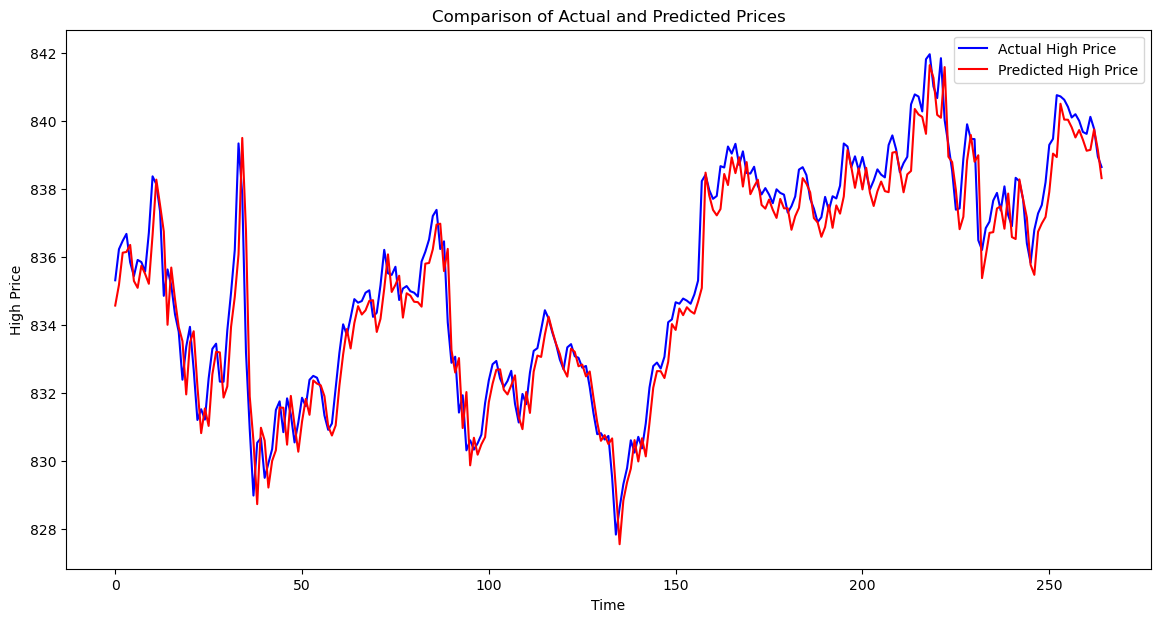

In [89]:
plt.figure(figsize=(14, 7))
plt.plot(y_val_rescaled, label='Actual High Price', color='blue')
plt.plot(y_pred_rescaled, label='Predicted High Price', color='red')
plt.title('Comparison of Actual and Predicted Prices')
plt.xlabel('Time')
plt.ylabel('High Price')
plt.legend()
plt.show()

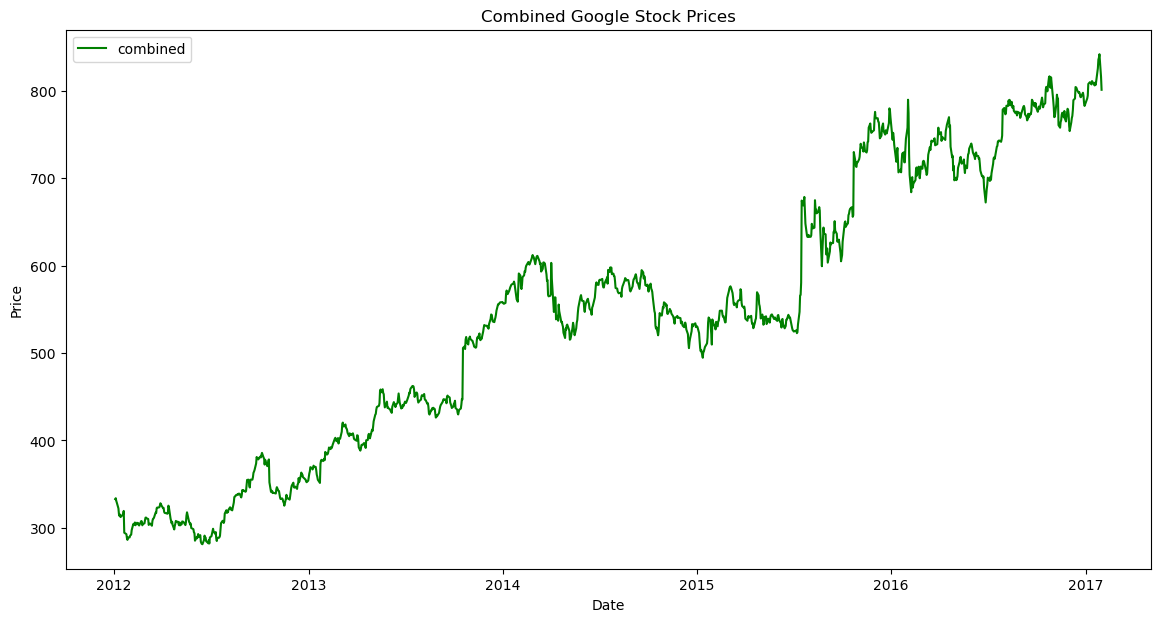

In [90]:
# Plot the combined data
plt.figure(figsize=(14, 7))

# Plot the part from df_test with another color
plt.plot(combined_df[['High']], label='combined', color='green')

plt.title('Combined Google Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [95]:
def create_dataset(dataset, look_back=1):
    X, y = [], []
    for i in range(len(dataset)-look_back):
        X.append(dataset[i:(i+look_back), 0])  # Take 'look_back' samples
        y.append(dataset[i+look_back, 0])       # Predict the next sample
    return np.array(X), np.array(y)

In [96]:
# Initialize and fit the scaler
scaler = MinMaxScaler(feature_range=(0, 1))
combined_scaled = scaler.fit_transform(combined_df[['High']])  # Scale the 'High' column

# Create sequences from the full combined scaled data
X_combined, y_combined = create_dataset(combined_scaled, look_back)
X_combined = X_combined.reshape((X_combined.shape[0], X_combined.shape[1], 1))  # Reshape for LSTM

# predict
predicted_prices_scaled = best_model.predict(X_combined)
predicted_prices = scaler.inverse_transform(predicted_prices_scaled)

# Append NaN values to align with the original data length for plotting
predicted_prices_full = np.append(np.empty((look_back,))*np.nan, predicted_prices.flatten())

39/39 [==============================] - 0s 4ms/step


In [97]:
df_test_compare = pd.read_csv('data/Google_Stock_Price_Test.csv')
df_test_compare['Date']=pd.to_datetime(df_test_compare['Date'])
df_test_compare.set_index('Date',drop=True,inplace=True)
df_test_compare['Volume'] = df_test_compare['Volume'].str.replace(',', '').astype(float)

Shape of test index: 20
Shape of predicted prices for test period: 20
Shape of actual high prices for test period: 20


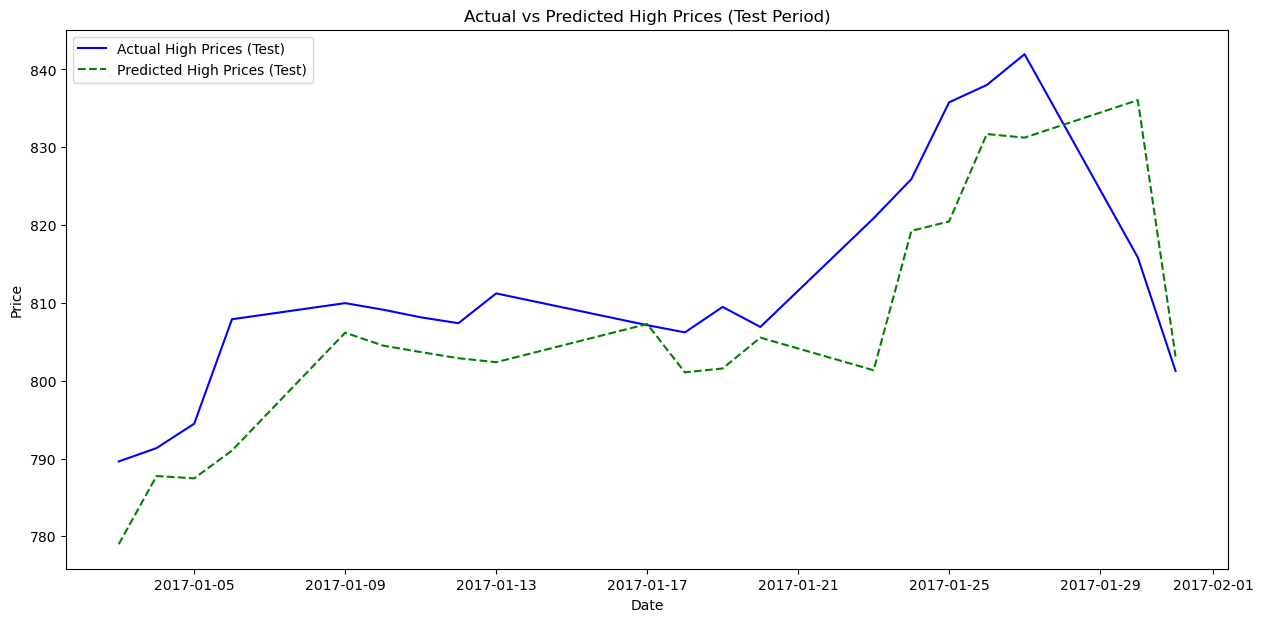

In [98]:
# Assuming 'look_back' is the number of lagged time steps used in the model
# Trim the predicted prices to match the length of the test set
predicted_prices_test_period = predicted_prices_full[-len(df_test.index):]

# Inverse transform the scaled actual high prices to compare with predictions
actual_high_prices = df_test_compare['High'] 

# Ensure the shapes by printing them out
print("Shape of test index:", len(df_test.index))
print("Shape of predicted prices for test period:", len(predicted_prices_test_period))
print("Shape of actual high prices for test period:", len(actual_high_prices))

# Plot the actual vs predicted prices for the test period
plt.figure(figsize=(15, 7))
plt.plot(df_test.index, actual_high_prices, label='Actual High Prices (Test)', color='blue')
plt.plot(df_test.index, predicted_prices_test_period, label='Predicted High Prices (Test)', color='green', linestyle='--')
plt.title('Actual vs Predicted High Prices (Test Period)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [101]:
# Assuming predicted_prices is a numpy array of predictions for the entire dataset
# And actual_prices is a numpy array of actual values corresponding to the latter part of predicted_prices

# Find the starting point for the actual prices within the predicted prices array
start_index = len(predicted_prices) - len(actual_high_prices)

# Slice the predicted prices to get the portion that corresponds to the actual prices
aligned_predicted_prices = predicted_prices[start_index:]

# # Ensure the arrays are of equal length
# if len(aligned_predicted_prices) > len(actual_prices):
#     aligned_predicted_prices = aligned_predicted_prices[:len(actual_prices)]

# Calculate MSE and MAE using the aligned data
mse = mean_squared_error(actual_high_prices, aligned_predicted_prices)
mae = mean_absolute_error(actual_high_prices, aligned_predicted_prices)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

Mean Squared Error (MSE): 96.54759939430146
Mean Absolute Error (MAE): 7.97280847167969
